<a href="https://colab.research.google.com/github/151ali/lr-pytorch/blob/main/7_GoogLeNet___InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

paper : [Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842)

In [1]:
import torch
import torch.nn as nn

In [2]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(ConvBlock, self).__init__()

    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(
        in_channels,
        out_channels,
        **kwargs
    )
    self.bn = nn.BatchNorm2d(out_channels) # not in the original paper

  def forward(self, x):
    return self.relu(self.bn(self.conv(x)))

In [3]:
class InceptionBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_1x1,
      red_3x3,
      out_3x3,
      red_5x5,
      out_5x5,
      out_1x1pool
  ):
      super(InceptionBlock, self).__init__()
      self.branch1 = nn.Sequential(
          ConvBlock(in_channels, out_1x1, kernel_size=(1, 1))
      )
      
      self.branch2 = nn.Sequential(
          ConvBlock(in_channels, red_3x3, kernel_size=(1, 1)),
          ConvBlock(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
      )

      self.branch3 = nn.Sequential(
          ConvBlock(in_channels, red_5x5, kernel_size=(1, 1)),
          ConvBlock(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
      )

      self.branch4 = nn.Sequential(
          nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          ConvBlock(in_channels, out_1x1pool, kernel_size=(1, 1)),
      )

  def forward(self, x):
      return torch.cat(
          [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
      )

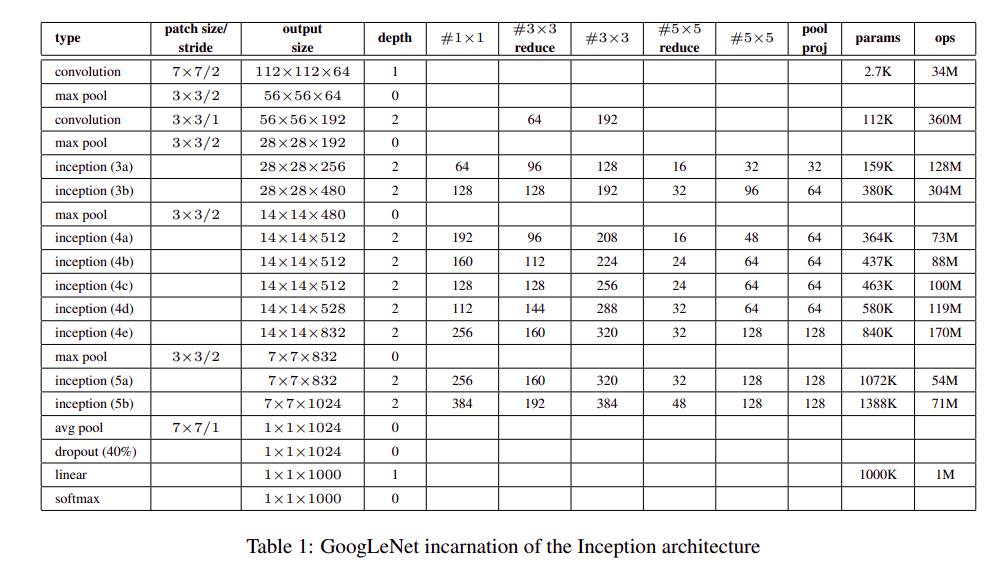

In [4]:
class GoogLeNet(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super(GoogLeNet, self).__init__()

    self.conv1 = ConvBlock(in_channels=in_channels, out_channels=64,
                           kernel_size=(7, 7),
                           stride=(2, 2),
                           padding=(3, 3)
    )
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = ConvBlock(64,192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


    self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

    self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc = nn.Linear(1024,num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)

    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = torch.flatten(x , 1)
    x = self.dropout(x)
    x = self.fc(x)
    #x = nn.Softmax(x)

    return x

In [5]:
model = GoogLeNet(in_channels=3, num_classes=10)

In [6]:
x = torch.randn(1,3,224,224)

In [7]:
model(x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.2099,  0.0883,  0.3162, -0.0590, -0.2958, -0.1519,  0.6134,  0.2045,
         -0.4362, -0.2855]], grad_fn=<AddmmBackward>)